In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Network Analysis of Fuel Distribution
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import Normalize
import seaborn as sns


plt.style.use('seaborn')
sns.set_palette("husl")

/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_25039/753063953.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [10]:
df = pd.read_parquet('../data/oil_and_gas_dataset.parquet')

# Network analysis

Node Addition:
State Nodes: Each Brazilian state is added as a node with attributes:
    type: Set to 'state' to distinguish from retailers
    avg_price: The average fuel price in that state
    establishments: Total number of fuel establishments in that state
    Retailer Nodes: Each fuel retailer brand is added as a node with attributes:
    type: Set to 'retailer' to distinguish from states
    avg_price: The average fuel price for that retailer
    establishments: Total number of establishments for that retailer

Edge Creation:
    For each state, we find all retailers operating in that state
    We create an edge between the state and each retailer
    The edge weight is set to the number of establishments that retailer has in that state
    This creates a bipartite graph structure (connections only between states and retailers, not state-state or retailer-retailer)

In [11]:
# Create a network graph of fuel distribution
print("Building network analysis of the fuel distribution system...")
G = nx.Graph()

# nodes for states and retailers
states = df['sigla_uf'].unique()
retailers = df['bandeira_revenda_cat'].unique()

# state nodes
for state in states:
    G.add_node(state, type='state', 
               avg_price=df[df['sigla_uf']==state]['avg_preco_venda'].mean(),
               establishments=df[df['sigla_uf']==state]['n_estabelecimentos'].sum())

# retailer nodes
for retailer in retailers:
    G.add_node(retailer, type='retailer',
               avg_price=df[df['bandeira_revenda_cat']==retailer]['avg_preco_venda'].mean(),
               establishments=df[df['bandeira_revenda_cat']==retailer]['n_estabelecimentos'].sum())

# edges between retailers and states based on presence
for state in states:
    state_retailers = df[df['sigla_uf']==state]['bandeira_revenda_cat'].unique()
    for retailer in state_retailers:
        # Calculate the weight based on number of establishments
        weight = df[(df['sigla_uf']==state) & 
                    (df['bandeira_revenda_cat']==retailer)]['n_estabelecimentos'].sum()
        G.add_edge(state, retailer, weight=weight)


Building network analysis of the fuel distribution system...


In [12]:
# degree centrality
degree_centrality = nx.degree_centrality(G)

# betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

# eigenvector centrality
#eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)

centrality_df = pd.DataFrame({
    'node': list(degree_centrality.keys()),
    'degree_centrality': list(degree_centrality.values()),
    'betweenness_centrality': list(betweenness_centrality.values()),
    # 'eigenvector_centrality': list(eigenvector_centrality.values())
})
centrality_df['type'] = centrality_df['node'].apply(
    lambda x: 'state' if x in states else 'retailer')




Visualizing the distribution network...


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_25039/2410636656.py:46: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='gray', connectionstyle='arc3,rad=0.1')


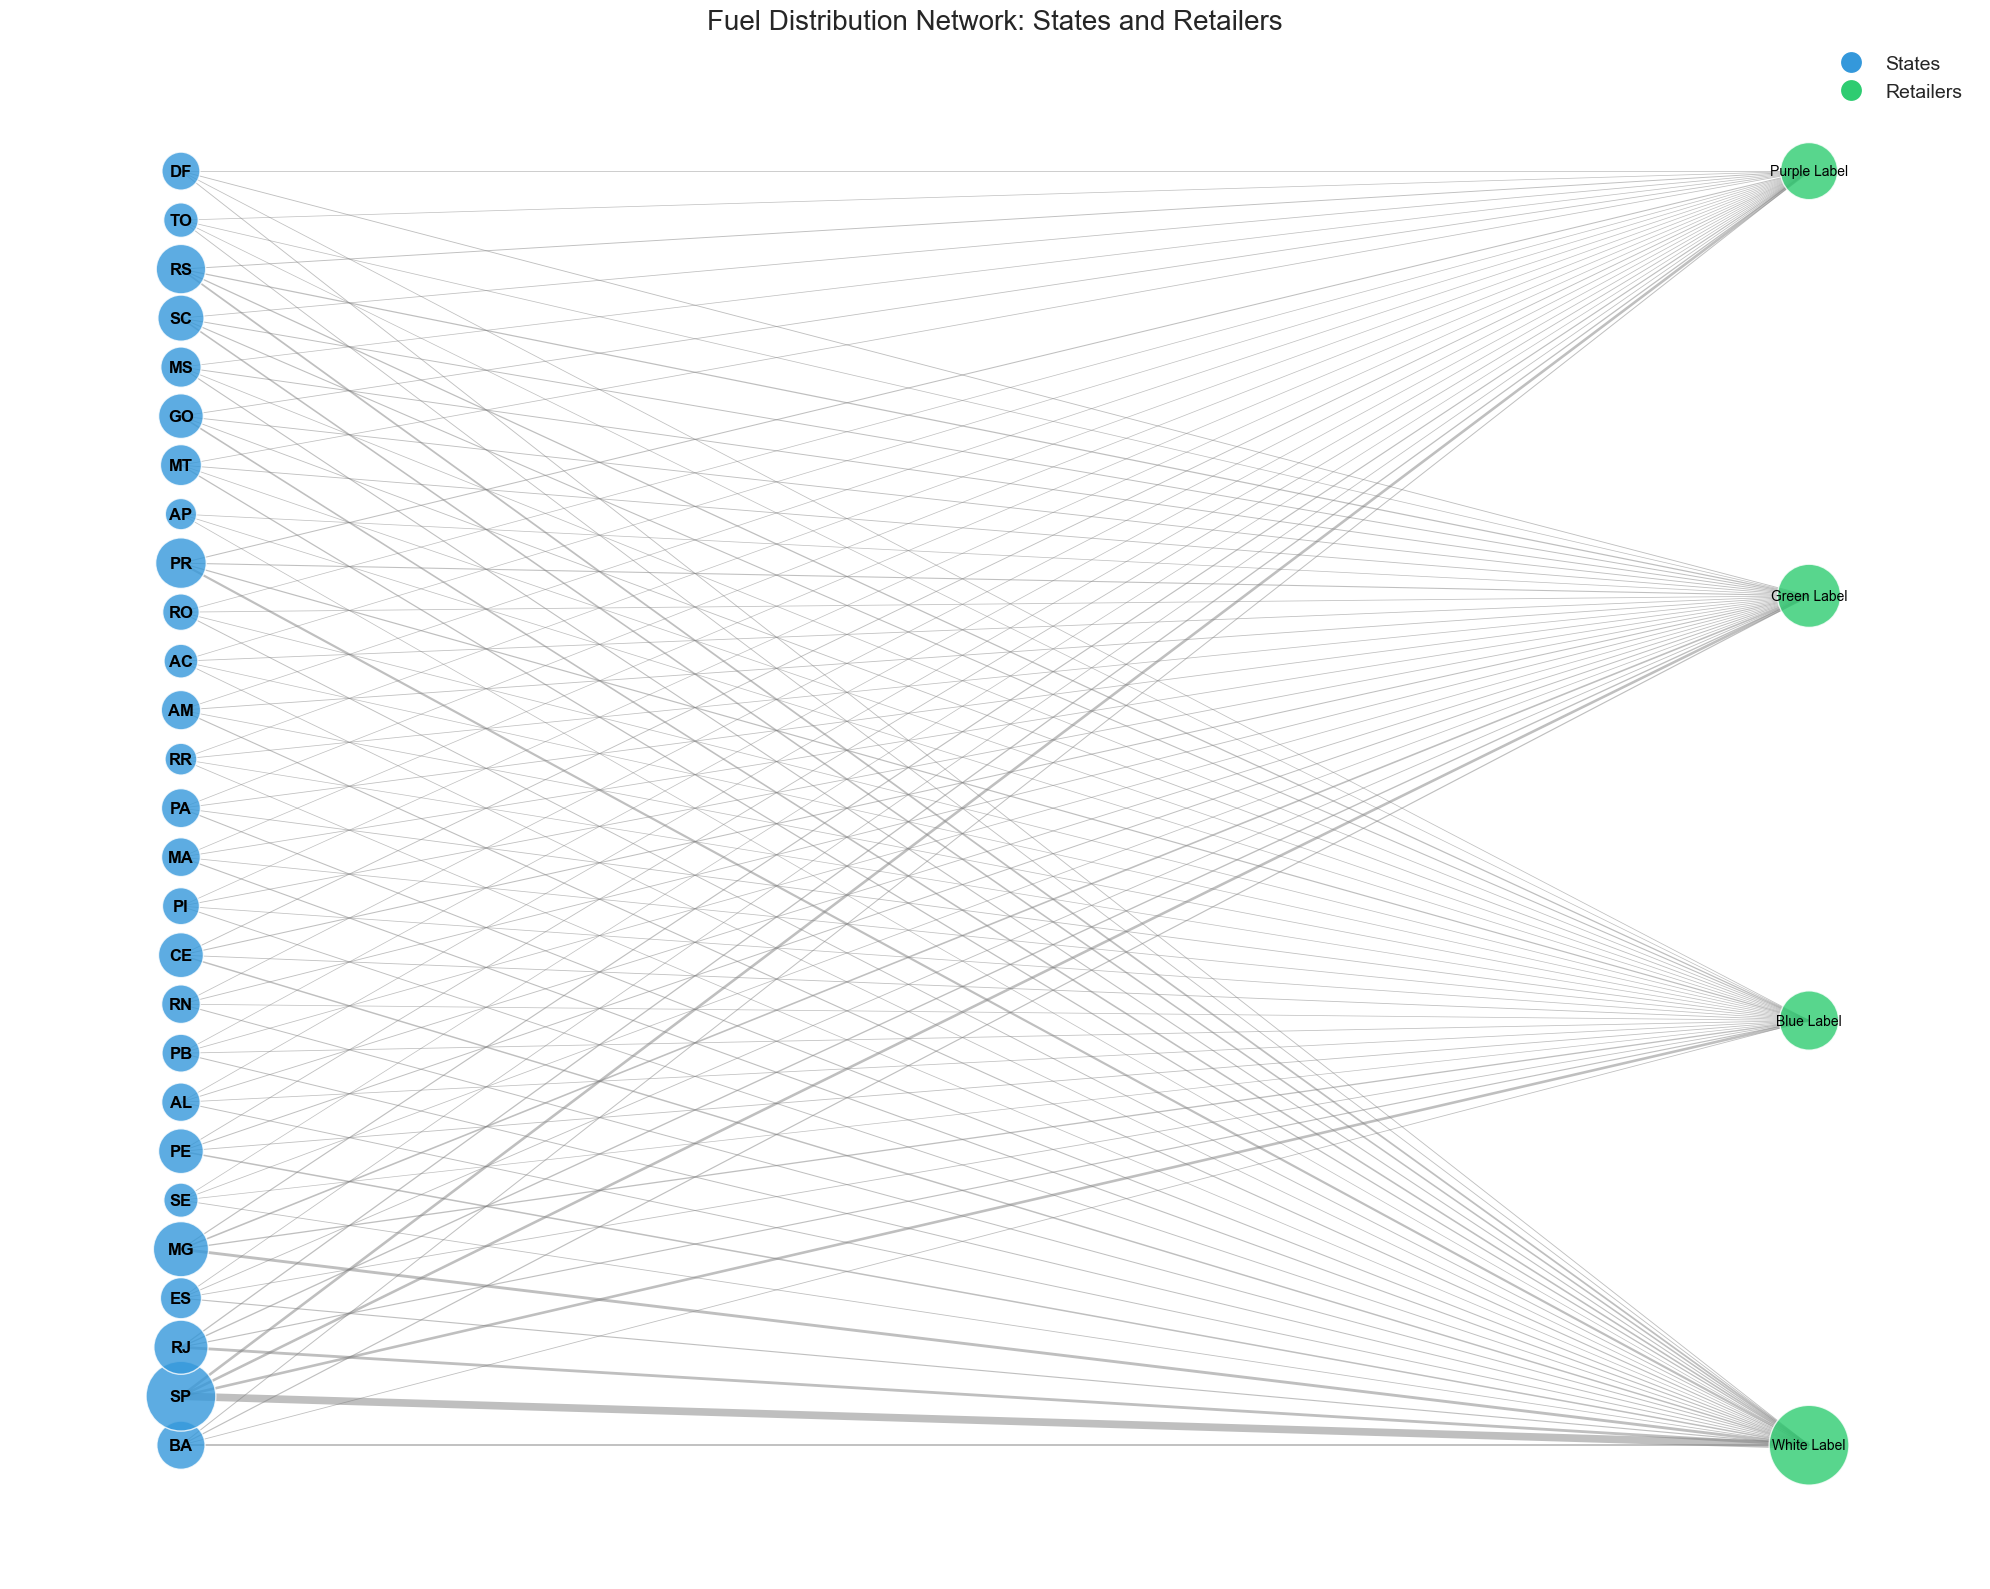

In [13]:
# Visualize the network
plt.figure(figsize=(20, 16))
print("\nVisualizing the distribution network...")

# bipartite layout 
state_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'state']
retailer_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'retailer']
pos = {}
# Position states on the left
for i, node in enumerate(state_nodes):
    pos[node] = (0.25, (i / (len(state_nodes) - 1 if len(state_nodes) > 1 else 1)) * 0.9 + 0.05)
# Position retailers on the right
for i, node in enumerate(retailer_nodes):
    pos[node] = (0.75, (i / (len(retailer_nodes) - 1 if len(retailer_nodes) > 1 else 1)) * 0.9 + 0.05)

# Get node sizes based on number of establishments with better scaling
node_sizes = []
max_establishments = max([G.nodes[node].get('establishments', 0) for node in G.nodes()])
for node in G.nodes():
    size = G.nodes[node].get('establishments', 0)
    # Scale the size for better visualization with a minimum size
    node_sizes.append(300 + (np.sqrt(size) / np.sqrt(max_establishments)) * 3000 if size > 0 else 300)

# Use more distinct colors for better visibility
state_color = '#3498db'  # Blue
retailer_color = '#2ecc71'  # Green

# Get node colors based on type
node_colors = []
for node in G.nodes():
    if G.nodes[node].get('type') == 'state':
        node_colors.append(state_color)
    else:
        node_colors.append(retailer_color)

# Get edge widths based on weight with better scaling
edge_widths = []
max_weight = max([G[u][v].get('weight', 1) for u, v in G.edges()])
for u, v in G.edges():
    width = G[u][v].get('weight', 1)
    # Scale the width for better visualization
    edge_widths.append(0.5 + (width / max_weight) * 5)

# Draw the network with improved aesthetics
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8, edgecolors='white', linewidths=1)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='gray', connectionstyle='arc3,rad=0.1')

# Improve label visibility
state_labels = {node: node for node in state_nodes}
retailer_labels = {node: node for node in retailer_nodes}

nx.draw_networkx_labels(G, pos, labels=state_labels, font_size=12, font_weight='bold', font_color='black')
nx.draw_networkx_labels(G, pos, labels=retailer_labels, font_size=10, font_color='black')

state_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=state_color, markersize=15, label='States')
retailer_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=retailer_color, markersize=15, label='Retailers')
plt.legend(handles=[state_patch, retailer_patch], loc='upper right', fontsize=14)

plt.title('Fuel Distribution Network: States and Retailers', fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()



Analyzing price influence patterns...


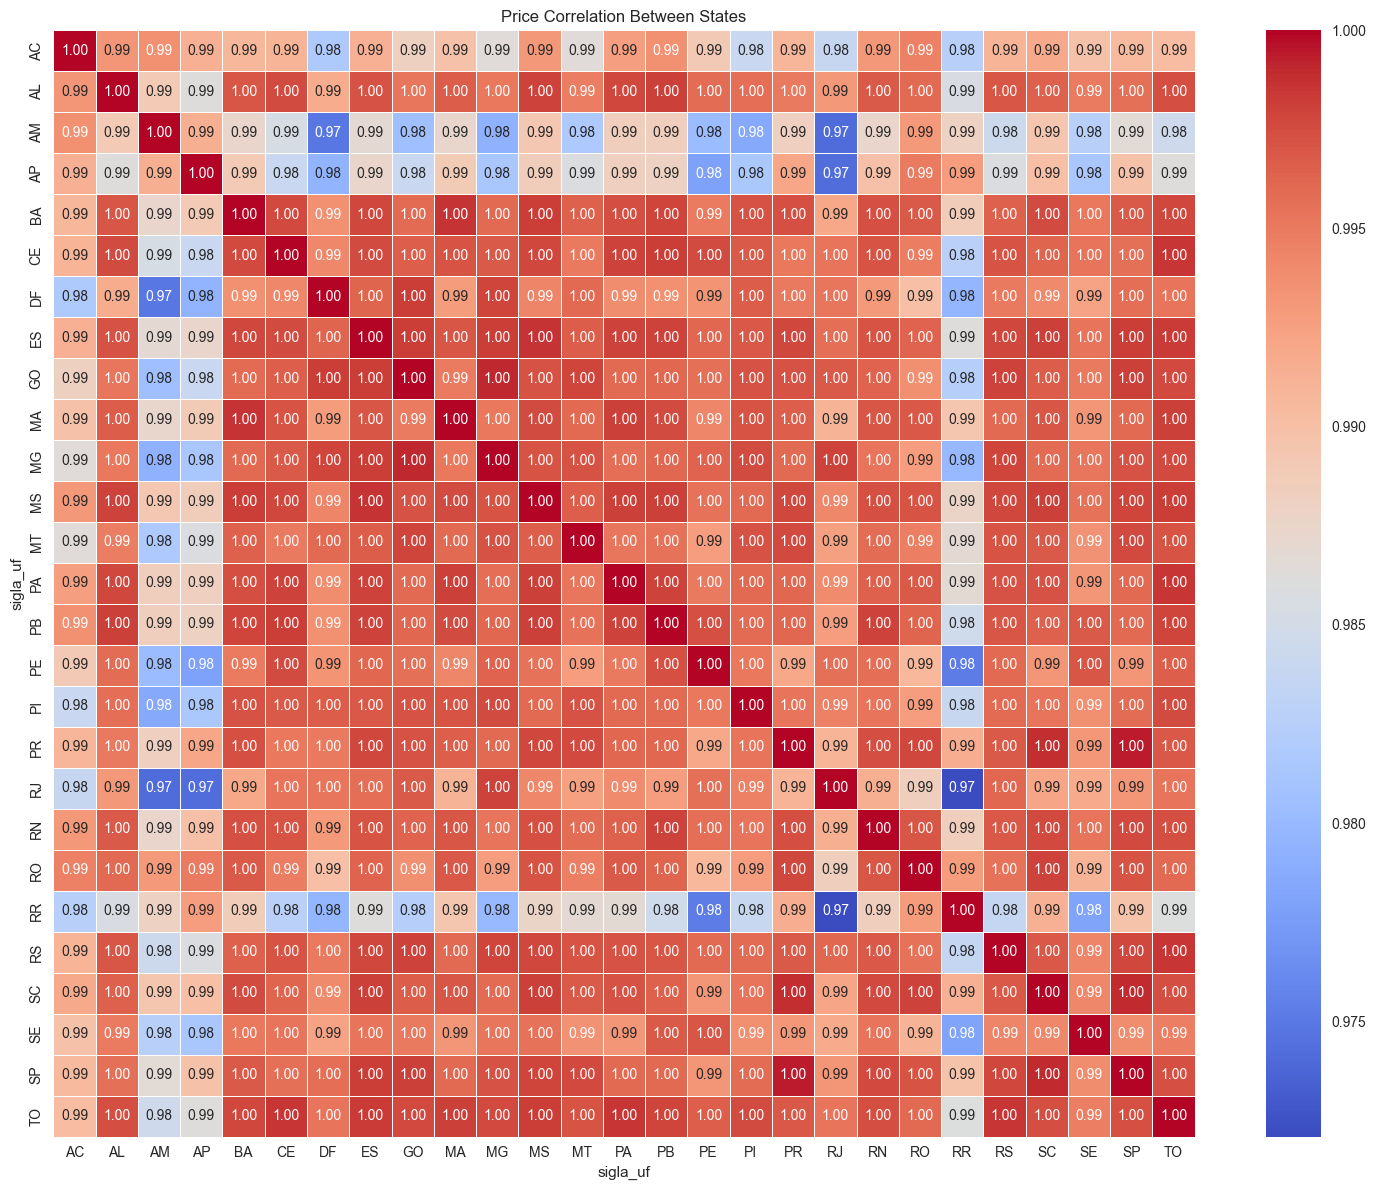

In [15]:
# Price influence analysis
print("\nAnalyzing price influence patterns...")

# Create a price influence matrix
influence_matrix = np.zeros((len(states), len(states)))
state_idx = {state: i for i, state in enumerate(states)}

# Calculate price correlations between states
price_by_state_date = df.groupby(['data', 'sigla_uf'])['avg_preco_venda'].mean().reset_index()
price_pivot = price_by_state_date.pivot(index='data', columns='sigla_uf', values='avg_preco_venda')

# Calculate correlation matrix
price_corr = price_pivot.corr()

# Visualize price correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(price_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Price Correlation Between States')
plt.tight_layout()
plt.show()


## Main takeaways

1. Universal Coverage vs. Focused Presence
The diagram suggests that each brand (White Label, Blue Label, Green Label, and Purple Label) has at least some presence in every state, though the intensity (number of stations or share of the market in each state) is not directly shown here.
Strategic Implication:
Even if all four brands appear statewide, some may have stronger or weaker footholds in certain regions. A deeper, state‐level count of establishments or sales volumes can reveal expansion or consolidation opportunities.

2. Overlapping Networks
All states are connected to multiple brands, meaning local competition is likely robust in most areas.
Strategic Implication:
The presence of competing brands across all states underscores the importance of region‐specific strategies—especially where a brand’s relative market share or brand equity might vary.

3. Brand Differentiation
Previous analyses indicate that brands like Green Label tend to compete on lower prices, while Purple Label commands premium pricing. This network view underscores that these strategies are playing out simultaneously in all or most states.
Strategic Implication:
To avoid brand cannibalization (if the same parent owns multiple labels), carefully manage brand positioning and pricing in each state.
If different entities own the brands, each must leverage local intelligence—such as competitor presence and consumer demographics—to refine pricing and promotions.

4. Potential for Supply Chain Synergies
Logistically, if certain states are under‐ or oversupplied by a given brand, rebalancing shipments could reduce transport costs or prevent stockouts.
Strategic Implication:
A brand with broad coverage (e.g., White Label) might move fuel from well‐supplied states to neighboring regions at risk of shortages.
This sort of “network optimization” can reduce overall costs, stabilize pricing, and maintain consistent margins.

In [ ]:
3